In [2]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib.animation import FuncAnimation
from numba import jit
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize
%matplotlib inline
from IPython.display import HTML

In [108]:
L =60
N = 100
Field_of_perception = 270
interior_angle = 0.5*np.radians(Field_of_perception)
eta = 0.05
dt = 0.1
time_step =50
v = 3
turning_rate = np.radians(40)
rr = 1
dro=12
dra=14
ro = rr+dro
ra = ro+dra

In [14]:
# MIC periodic distance
@jit(nopython=True)
def periodic_distance(point1, point2, box_size):
    diff = point1 - point2
    diff = np.mod(diff + box_size / 2, box_size) - box_size / 2
    return np.sqrt(np.sum(diff ** 2))

def angle_between(point1, point2, dir1):
    v1 = dir1
    v2 = (point2 - point1)
    norm1 = np.linalg.norm(v1, axis=-1)
    norm2 = np.linalg.norm(v2, axis=-1)
    zero_mask1 = (norm1 == 0)
    zero_mask2=(norm2 == 0)
    norm1[zero_mask1] = 1
    norm2[zero_mask2] = 1
    cos_angles = np.sum(v1 * v2, axis=-1) / (norm1 * norm2)
    cos_angles = np.clip(cos_angles, -1.0, 1.0)
    return np.arccos(cos_angles)


def periodic(pos_array,L):
    #signs!!!!!!
    diff=pos_array-pos_array[:,np.newaxis,:]
    uper=(diff>L/2)
    lower=(diff<-L/2)
    return np.where(uper, -L,0)+np.where(lower,L,0)

def angle_between_p(point1, point2, dir1,pos_array,L):
    dif_b=periodic(pos_array,L) ###############
    v1 = dir1
    v2 = (point2 - point1) +dif_b
    norm1 = np.linalg.norm(v1, axis=-1)
    norm2 = np.linalg.norm(v2, axis=-1)
    zero_mask1 = (norm1 == 0)
    zero_mask2 = (norm2 == 0)
    norm1[zero_mask1] = 1
    norm2[zero_mask2] = 1
    cos_angles = np.sum(v1 * v2, axis=-1) / (norm1 * norm2)
    cos_angles = np.clip(cos_angles, -1.0, 1.0)
    return np.arccos(cos_angles)

def field_of_perception(pos_array, dir_array, interior_angle,L):
    angles = angle_between_p(pos_array[:, None], pos_array[None, :],np.reshape(np.tile(dir_array[:, None], (1, 1, N)), (N, N, 3)),pos_array,L )
    np.fill_diagonal(angles,0)
    mask = (angles <= interior_angle)
    mask[np.isnan(angles)] = False
    return mask

def tendency(pos_matrix, pos_array,mask,L):
    dif_b = periodic(pos_array,L)###############
    dif = (pos_matrix - pos_array.reshape(N, 1, 3))+dif_b
    dif*=mask[:, :, np.newaxis]

    squared_dir_matrix = dif ** 2
    squared_sum = squared_dir_matrix.sum(axis=-1)
    norm_v = np.zeros_like(dif)

    nonzero_mask = squared_sum != 0
    norm_v[nonzero_mask] = dif[nonzero_mask] / np.sqrt(squared_sum[nonzero_mask])[:, np.newaxis]

    norm_v[np.isnan(norm_v)] = 0
    norm_v *= mask[:, :, np.newaxis]
    dr = np.sum(norm_v, axis=1)
    return normalize(dr, axis=1, norm='l2')


def align(dir_matrix,mask,pos_array,L):
    squared_dir_matrix = dir_matrix ** 2
    squared_sum = squared_dir_matrix.sum(axis=-1)
    norm_v = np.zeros_like(dir_matrix)

    nonzero_mask = squared_sum != 0
    norm_v[nonzero_mask] = dir_matrix[nonzero_mask] / np.sqrt(squared_sum[nonzero_mask])[:, np.newaxis]

    norm_v[np.isnan(norm_v)] = 0
    norm_v*=mask[:, :, np.newaxis]
    dr=np.sum(norm_v, axis=1)
    return normalize(dr, axis=1, norm='l2')

def neighbor(pos_array, radius_down, radius_up):
    dist = cdist(pos_array, pos_array, metric=lambda x, y: periodic_distance(x, y, L))
    neighbors = np.logical_and(radius_down < dist, dist < radius_up)
    return neighbors

def rotate_vector(v1, v2, theta):

    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    axis = np.cross(v1, v2)
    angle = theta
    rot_matrix = np.array([[np.cos(angle) + axis[0] ** 2 * (1 - np.cos(angle)),
                            axis[0] * axis[1] * (1 - np.cos(angle)) - axis[2] * np.sin(angle),
                            axis[0] * axis[2] * (1 - np.cos(angle)) + axis[1] * np.sin(angle)],
                           [axis[1] * axis[0] * (1 - np.cos(angle)) + axis[2] * np.sin(angle),
                            np.cos(angle) + axis[1] ** 2 * (1 - np.cos(angle)),
                            axis[1] * axis[2] * (1 - np.cos(angle)) - axis[0] * np.sin(angle)],
                           [axis[2] * axis[0] * (1 - np.cos(angle)) - axis[1] * np.sin(angle),
                            axis[2] * axis[1] * (1 - np.cos(angle)) + axis[0] * np.sin(angle),
                            np.cos(angle) + axis[2] ** 2 * (1 - np.cos(angle))]])
    v = np.squeeze(normalize([rot_matrix.dot(v1)],'l2'))

    return v


def turning(new_dir_array, dir_array, turning_rate):
    angles=angle_between(np.zeros((N,3)), dir_array, new_dir_array)
    mask=angles<turning_rate * dt
    indexs=np.squeeze(np.argwhere(mask == False))
    for i in indexs:
        new_dir_array[i] = rotate_vector(dir_array[i], new_dir_array[i], turning_rate * dt)
    # for i in range(len(new_dir_array)):
    #     a = angle(new_dir_array[i], dir_array[i])
    #     if np.abs(a) > turning_rate * dt:
    #         new_dir_array[i] = rotate_vector(dir_array[i],new_dir_array[i],  turning_rate * dt)
    # for i in range(len(new_dir_array)):
    #     a = angle(new_dir_array[i], dir_array[i])
    #     if np.abs(a) > turning_rate * dt:
    #         new_dir_array[i] = rotate_vector(dir_array[i],new_dir_array[i],  turning_rate * dt)

    return new_dir_array
def generate_random_neighbors(neighbors):
    return np.random.randint(neighbors)

def random_selected_partical(matrix,indices):
    """

    :param matrix: nighbours matrix(boolean matrix)
    :param indices: 1d array that contain nth True value(the random select partical)
    :return: the index of each selected particals
    """
    true_palce = np.column_stack(np.where(matrix))
    split_arr = np.split(true_palce[:, 1], np.unique(true_palce[:, 0], return_index=True)[1][1:])
    result = np.empty(len(split_arr))
    for i in range(len(split_arr)):
        if np.isnan(indices[i]):
            result[i] = i
        else:
            result[i] = split_arr[i][indices[i]]
    return result.astype(int)

def update(pos_array, dir_array, rr, ro, ra, turning_rate,L,comr):
    filed = field_of_perception(pos_array, dir_array, interior_angle,L)
    angles=angle_between(np.zeros((N,3)),dir_array[ None,:],dir_array[:, None])
    neighr, neigho, neigha, neigh = neighbor(pos_array, 0, rr), \
                                    neighbor(pos_array, rr, ro ) * filed, \
                                    neighbor(pos_array,ro ,ra)* filed, \
                                    neighbor(pos_array, 0, ra)* filed

    in_r = (np.sum(neighr, axis=1) > 0)
    in_o = (np.sum(neigho, axis=1) > 0)
    in_a = (np.sum(neigha, axis=1) > 0)
    around = (np.sum(neigh, axis=1) > 0)

    pos_matrix = np.tile(pos_array, (N, 1)).reshape(N, N, 3)
    dir_matix=np.tile(dir_array, (N, 1)).reshape(N, N, 3)

    dr = -1*tendency(pos_matrix , pos_array,neighr,L)
    do = align(dir_matix,neigho,pos_array,L)
    da = tendency(pos_matrix , pos_array,neigha,L)

    in_o_not_r = in_o * ~in_r
    in_a_not_r = in_a * ~in_r

    in_o_and_a = in_o_not_r * in_a_not_r

    just_in_o = in_o_not_r * ~in_o_and_a
    just_in_a = in_a_not_r * ~in_o_and_a

    ##############
    # ne=neigh

    ne = neighbor(pos_array, 0, comr)
    np.fill_diagonal(ne, True)
    neigh_dir=dir_matix * ne[:, :, np.newaxis]
    num_neighbors=np.sum(ne, axis=1)

    r_l = np.linalg.norm(np.sum(neigh_dir, axis=1),axis=1) / (num_neighbors)
    # communication cost
    c_l = s * comr / L  # 1-d array
    # payoff earned by an agent l
    p_l = r_l - alp * c_l  # 1-d array
    p_l[np.where(num_neighbors == 1)]=0
    # Fermi rule
    index_of_randomly_partical = random_selected_partical(ne, generate_random_neighbors(num_neighbors))
    p_m = p_l[index_of_randomly_partical]
    w = 1 / (1 + (np.exp((p_l - p_m) / beta)))
    random_selected_particla_s = s[index_of_randomly_partical]
    convert = random_selected_particla_s - s
    w[np.where(convert == -1)] = 1 - w[np.where(convert == -1)]
    w[np.where(convert == 0)] = s[np.where(convert == 0)]
    new_s = []
    for i in range(len(s)):
        new_s.append(np.random.choice([0, 1], p=[1 - w[i], w[i]]))

    new_s = np.array(new_s)
    #############

    new_dir = dr * in_r[:, np.newaxis] + do * just_in_o[:, np.newaxis] + da * just_in_a[:, np.newaxis] + 0.5 * (
            do + da) * in_o_and_a[:, np.newaxis] + dir_array * ~around[:, np.newaxis]
    new_dir=normalize(new_dir,axis=1)
    err = np.random.normal(loc=0, scale=eta, size=(N, 3))
    new_dir += err
    random_theta = normalize(np.random.uniform(low=-1, high=1, size=(N, 3)), axis=1, norm='l2')
    new_dir[np.where(new_s == 0)] = random_theta[np.where(new_s == 0)] #random but turning angle
    update_dir = turning(new_dir, dir_array, turning_rate)
    # update_dir[np.where(new_s == 0)] = random_theta[np.where(new_s == 0)]
    return normalize(update_dir,axis=1,norm='l2'), new_s,0.5*np.sum(angles)/(N**2-N),r_l,p_l



0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0


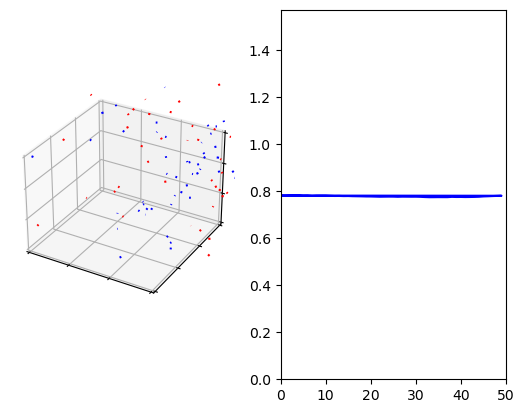

In [109]:
alp=0
beta=1
comr=6
pos_array = L* np.random.rand(N, 3)
dir_array = normalize(np.random.uniform(low=-1, high=1, size=(N, 3)),axis=1, norm='l2')
s = np.random.randint(2, size=N)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_zlim3d(bottom=0, top=L)
ax.set_xlim3d(left=0, right=L)
ax.set_ylim3d(bottom=0, top=L)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

quiver = ax.quiver(pos_array[:, 0], pos_array[:, 1], pos_array[:, 2], dir_array[:, 0], dir_array[:, 1], dir_array[:, 2],
                   length=1.0, normalize=True, arrow_length_ratio=0.8)


ax2d = fig.add_subplot(1, 2, 2)
ax2d.set_xlim(0, time_step)
ax2d.set_ylim(0, np.pi/2)
line, = ax2d.plot([], [], 'b-')

ang=[]
order=[]
time=[]
payoff=[]
strategy=[]
def update_quiver(t):
    global pos_array, dir_array, quiver,s
    dir_array,st,angles,r_l,p_l= update(pos_array, dir_array, rr, ro, ra, turning_rate,L,comr)
    ang.append(angles)
    order.append(r_l)
    time.append(t)
    payoff.append(p_l)
    vel_array = v * dir_array
    pos_array += vel_array * dt
    pos_array = np.mod(pos_array, L)
    strategy.append(st)
    s = st
    quiver.set_offsets(pos_array)
    new_seg = np.concatenate((pos_array[:, np.newaxis, :], pos_array[:, np.newaxis, :] + dir_array[:, np.newaxis, :]),
                             axis=1).reshape(N, 2, 3)
    quiver.set_segments(new_seg)
    C=np.where(st, 'b', 'r')
    quiver.set_color(C)
    line.set_data(time, ang)
    print(t)
    return quiver, line


anim = FuncAnimation(fig, update_quiver, frames=time_step, interval=10)
HTML(anim.to_html5_video())

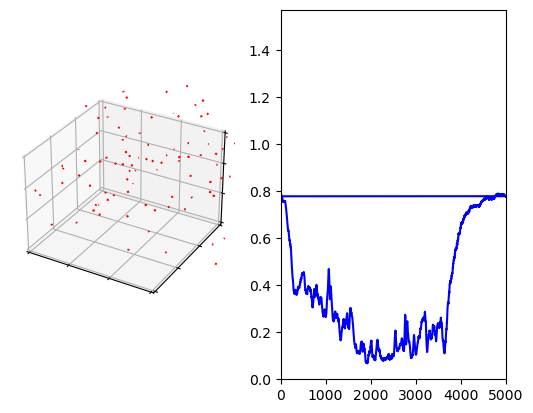

In [16]:
alp=1
beta=1
comr=6
pos_array = L* np.random.rand(N, 3)
dir_array = normalize(np.random.uniform(low=-1, high=1, size=(N, 3)),axis=1, norm='l2')
s = np.random.randint(2, size=N)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_zlim3d(bottom=0, top=L)
ax.set_xlim3d(left=0, right=L)
ax.set_ylim3d(bottom=0, top=L)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

quiver = ax.quiver(pos_array[:, 0], pos_array[:, 1], pos_array[:, 2], dir_array[:, 0], dir_array[:, 1], dir_array[:, 2],
                   length=1.0, normalize=True, arrow_length_ratio=0.8)


ax2d = fig.add_subplot(1, 2, 2)
ax2d.set_xlim(0, time_step)
ax2d.set_ylim(0, np.pi/2)
line, = ax2d.plot([], [], 'b-')

ang=[]
order=[]
time=[]
payoff=[]
strategy=[]
def update_quiver(t):
    global pos_array, dir_array, quiver,s
    dir_array,st,angles,r_l,p_l= update(pos_array, dir_array, rr, ro, ra, turning_rate,L,comr)
    ang.append(angles)
    order.append(r_l)
    time.append(t)
    payoff.append(p_l)
    vel_array = v * dir_array
    pos_array += vel_array * dt
    pos_array = np.mod(pos_array, L)
    strategy.append(st)
    s = st
    quiver.set_offsets(pos_array)
    new_seg = np.concatenate((pos_array[:, np.newaxis, :], pos_array[:, np.newaxis, :] + dir_array[:, np.newaxis, :]),
                             axis=1).reshape(N, 2, 3)
    quiver.set_segments(new_seg)
    C=np.where(st, 'b', 'r')
    quiver.set_color(C)
    line.set_data(time, ang)
    return quiver, line


anim = FuncAnimation(fig, update_quiver, frames=time_step, interval=10)
HTML(anim.to_html5_video())

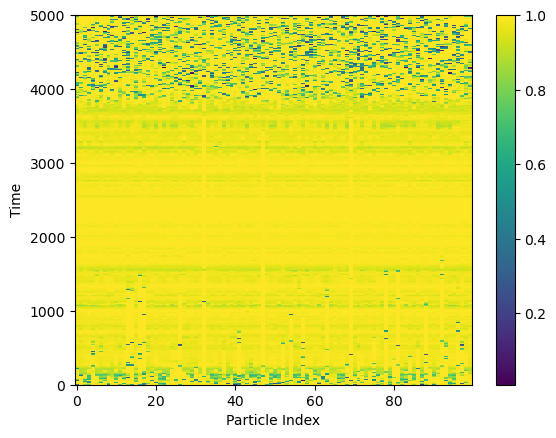

In [72]:
data = np.array(order)

# Creating a meshgrid for the x and y coordinates
x = np.arange(data.shape[1])
y = np.arange(data.shape[0])
X, Y = np.meshgrid(x, y)

# Plotting the color plot
plt.pcolormesh(X, Y, data, cmap='viridis', shading='auto')
plt.colorbar()  # Add colorbar for reference

# Labeling the axes
plt.xlabel('Particle Index')
plt.ylabel('Time')
# Displaying the plot
plt.show()

In [65]:
np.savez('/Users/junheqiao/honours project mini/test',ang=ang,order=order,time=time,payoff=payoff,strategy=strategy)

In [66]:
tr=np.load('/Users/junheqiao/honours project mini/test.npz')

In [70]:
np.where(strategy[3500]==0)

(array([32, 69]),)

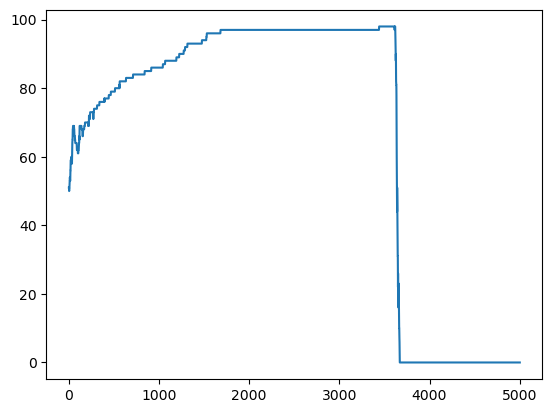

In [29]:
plt.plot(np.sum(strategy,axis=1))

In [66]:
angel=[]
alp=0
beta=1
comr=6
for i in np.arange(0,11):
    pos_array = L * np.random.rand(N, 3)
    dir_array = normalize(np.random.uniform(low=-1, high=1, size=(N, 3)), axis=1, norm='l2')
    s = np.random.randint(2, size=N)
    for i in range(time_step):
        dir_array,st,angles,r_l,p_l= update(pos_array, dir_array, rr, ro, ra, turning_rate,L,comr)
        vel_array = v * dir_array
        pos_array += vel_array * dt
        pos_array = np.mod(pos_array, L)
        s = st
    angel.append(angles)

In [67]:
angel

[0.051832728794394614,
 0.03237413856395458,
 0.04515807925961152,
 0.04477606822434776,
 0.04671446016705673,
 0.04621836121697432,
 0.04342374380990557,
 0.05039895914025505,
 0.04482500434388955,
 0.05216918441579362,
 0.049530349074515756]

In [ ]:
an=[]
alp=0
beta=1
comr=6
for i in np.arange(0,11):
    pos_array = L * np.random.rand(N, 3)
    dir_array = normalize(np.random.uniform(low=-1, high=1, size=(N, 3)), axis=1, norm='l2')
    s = np.random.randint(2, size=N)
    for i in range(time_step):
        dir_array,st,angles,r_l,p_l= update(pos_array, dir_array, rr, ro, ra, turning_rate,L,comr)
        vel_array = v * dir_array
        pos_array += vel_array * dt
        pos_array = np.mod(pos_array, L)
        s = st

In [11]:
an=[]
comr=6
for alp in np.arange(0.05,1.05,0.05):
    for beta in np.arange(0.05,1.05,0.05):
        pos_array = L * np.random.rand(N, 3)
        dir_array = normalize(np.random.uniform(low=-1, high=1, size=(N, 3)), axis=1, norm='l2')
        s = np.random.randint(2, size=N)
        for i in range(time_step):
            dir_array,st,angles,r_l,p_l= update(pos_array, dir_array, rr, ro, ra, turning_rate,L,comr)
            vel_array = v * dir_array
            pos_array += vel_array * dt
            pos_array = np.mod(pos_array, L)
            s = st
        an.append(angles)

Text(0.5, 1.0, 'Scatter Plot')

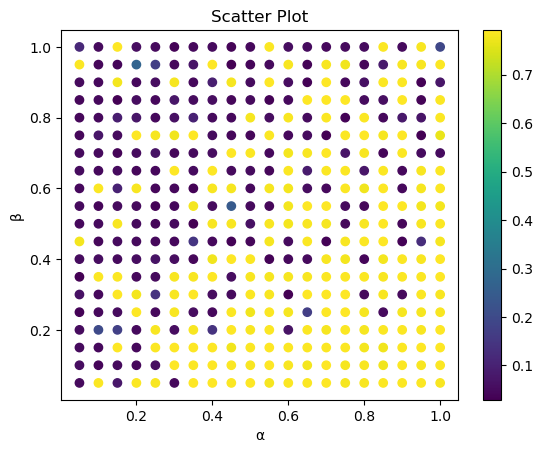

In [21]:
x = np.arange(0.05, 1.05, 0.05)
y = np.arange(0.05, 1.05, 0.05)
plt.scatter(x.repeat(20), np.tile(y, 20), c=an, cmap='viridis')
plt.colorbar()
plt.xlabel('\u03B1')
plt.ylabel('\u03B2')

In [62]:
# np.savez('/Users/junheqiao/honours project mini/simulation', an ,an1, an2,an3)

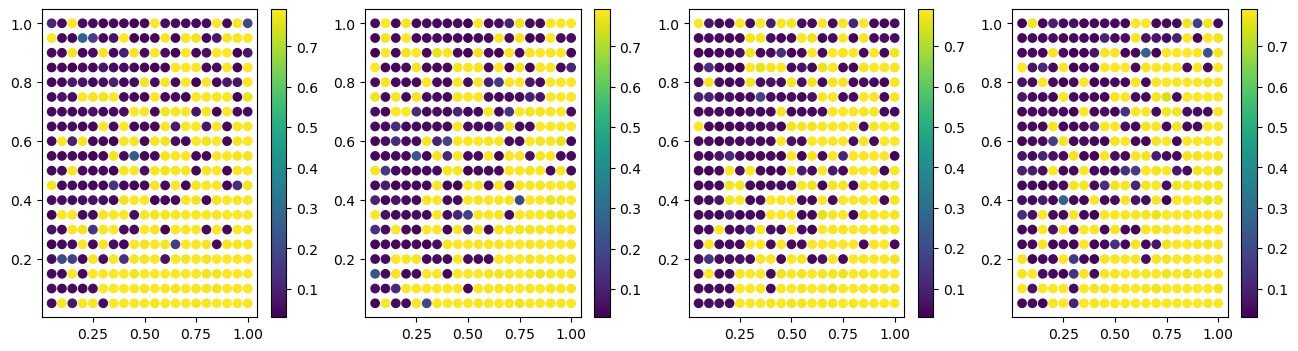

In [10]:

data=np.load('/Volumes/lexar/simulation.npz')
an ,an1, an2,an3=data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']
# Create x and y coordinates
x = np.arange(0.05, 1.05, 0.05)
y = np.arange(0.05, 1.05, 0.05)

# Create a figure and axes
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

# Plot the first scatter plot
sc1 = ax[0].scatter(x.repeat(20), np.tile(y, 20), c=an, cmap='viridis')
plt.colorbar(sc1, ax=ax[0])
# Plot the second scatter plot
sc2 = ax[1].scatter(x.repeat(20), np.tile(y, 20), c=an1, cmap='viridis')
plt.colorbar(sc2, ax=ax[1])

# Plot the third scatter plot
sc3 = ax[2].scatter(x.repeat(20), np.tile(y, 20), c=an2, cmap='viridis')
plt.colorbar(sc3, ax=ax[2])

sc4 = ax[3].scatter(x.repeat(20), np.tile(y, 20), c=an3, cmap='viridis')
plt.colorbar(sc4, ax=ax[3])
# Show the plot
plt.show()

In [9]:
data.files

['arr_0', 'arr_1', 'arr_2', 'arr_3']

Text(0, 0.5, 'β')

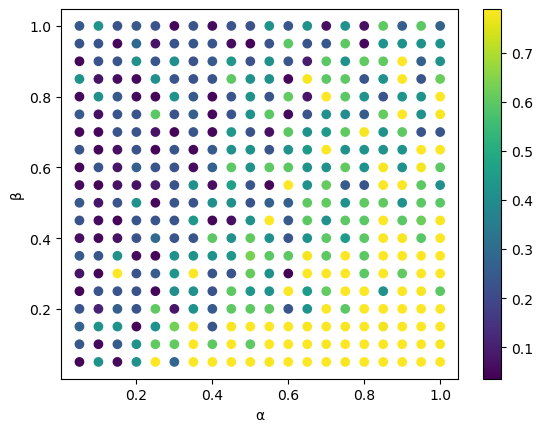

In [100]:
x = np.arange(0.05, 1.05, 0.05)
y = np.arange(0.05, 1.05, 0.05)
plt.scatter(x.repeat(20), np.tile(y, 20), c=(np.array(an1)+np.array(an)+np.array(an2)+np.array(an3))/4, cmap='viridis')
plt.colorbar()
plt.xlabel('\u03B1')
plt.ylabel('\u03B2')

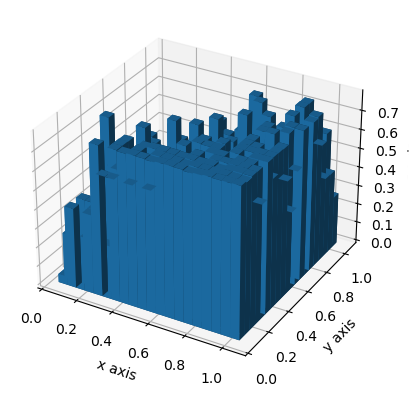

In [81]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
arra=np.arange(0.05, 1.05, 0.05)

x3 = np.repeat(arra, len(arra))
y3 = np.tile(arra, len(arra))
z3 = np.zeros(len(x3))

dx = np.ones(len(x3))*0.05
dy = np.ones(len(x3))*0.05
dz = (np.array(an1)+np.array(an)+np.array(an2)+np.array(an3))/4

ax1.bar3d(x3, y3, z3, dx, dy, dz)


ax1.set_xlabel('x axis')
ax1.set_ylabel('y axis')
ax1.set_zlabel('z axis')

plt.show()


In [78]:
(np.array(an1)+np.array(an)+np.array(an2)+np.array(an3))/4

array([0.04395159, 0.24010119, 0.27492826, 0.23428713, 0.04293641,
       0.07125509, 0.24808453, 0.06510332, 0.2281712 , 0.24299463,
       0.05579407, 0.04267761, 0.23477502, 0.04803259, 0.24927236,
       0.05476649, 0.41801841, 0.04296011, 0.22948716, 0.24735675,
       0.41986892, 0.05099823, 0.41730672, 0.107533  , 0.23250087,
       0.04711883, 0.23991117, 0.04739038, 0.05659655, 0.07906339,
       0.04269696, 0.23615014, 0.04601705, 0.04952901, 0.06620626,
       0.41392742, 0.07309809, 0.22858429, 0.23051763, 0.42268262,
       0.05523529, 0.25110656, 0.41727245, 0.26489336, 0.23309963,
       0.78904389, 0.41413068, 0.06847037, 0.04225752, 0.23501603,
       0.07033846, 0.07703983, 0.06348989, 0.23044083, 0.23303307,
       0.24524806, 0.05893876, 0.23107322, 0.04911976, 0.22782926,
       0.41582452, 0.4181436 , 0.04647607, 0.23486836, 0.22965712,
       0.23462859, 0.05716716, 0.22975253, 0.23083948, 0.41734262,
       0.06806518, 0.26159853, 0.22864496, 0.23325694, 0.23338

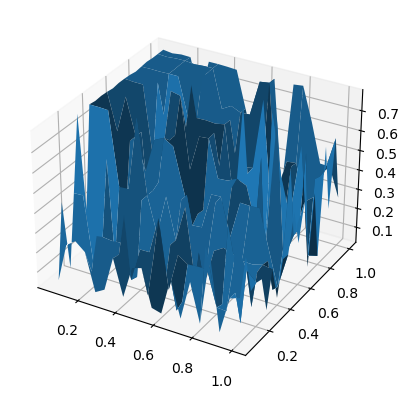

In [107]:
x = np.arange(0.05, 1.05, 0.05)
y = np.arange(0.05, 1.05, 0.05)

X, Y = np.meshgrid(x, y)
z3 = (np.array(an1)+np.array(an)+np.array(an2)+np.array(an3))/4
# z3 = np.array(an1)
Z=z3.reshape((20, 20))
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the wireframe
ax.plot_surface(X,Y,Z,rstride=3, cstride=3)

In [83]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [91]:
X

array([[0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3